In [16]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv("../data/processed/istihdam_preprocessed.csv")

In [3]:
X = df.drop(columns=['istihdam_orani'])
y = df['istihdam_orani']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return r2, mse, mae, rmse

Random Forest

In [4]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics_rf = evaluate_model(y_test, y_pred_rf)

Gradient Boosting

In [5]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
metrics_gb = evaluate_model(y_test, y_pred_gb)

KNN

In [6]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
metrics_knn = evaluate_model(y_test, y_pred_knn)

SVR

In [7]:
svr = SVR()
svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)
metrics_svr = evaluate_model(y_test, y_pred_svr)

ANN (Simple)

In [8]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_ann.compile(optimizer='adam', loss='mse')

model_ann.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

y_pred_ann = model_ann.predict(X_test_scaled).flatten()
metrics_ann = evaluate_model(y_test, y_pred_ann)

c:\Users\nurha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Deep ANN + Dropout

In [9]:
model_deep = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model_deep.compile(optimizer='adam', loss='mse')

model_deep.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

y_pred_deep = model_deep.predict(X_test_scaled).flatten()
metrics_deep = evaluate_model(y_test, y_pred_deep)

c:\Users\nurha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


In [18]:
results = pd.DataFrame({
    "Model": [
        "Random Forest",
        "Gradient Boosting",
        "KNN",
        "SVR",
        "ANN (Simple)",
        "ANN (Deep + Dropout)"
    ],
    "R2": [
        metrics_rf[0],
        metrics_gb[0],
        metrics_knn[0],
        metrics_svr[0],
        metrics_ann[0],
        metrics_deep[0]
    ],
    "MSE": [
        metrics_rf[1],
        metrics_gb[1],
        metrics_knn[1],
        metrics_svr[1],
        metrics_ann[1],
        metrics_deep[1]
    ],
    "MAE": [
        metrics_rf[2],
        metrics_gb[2],
        metrics_knn[2],
        metrics_svr[2],
        metrics_ann[2],
        metrics_deep[2]
    ],
    "RMSE": [
        metrics_rf[3],
        metrics_gb[3],
        metrics_knn[3],
        metrics_svr[3],
        metrics_ann[3],
        metrics_deep[3]
    ]
})

print(results)

                  Model        R2         MSE        MAE       RMSE
0         Random Forest  0.906275   31.858653   2.921080   5.644347
1     Gradient Boosting  0.916362   28.429889   3.007144   5.331969
2                   KNN  0.381197  210.341206  11.189445  14.503145
3                   SVR  0.075417  314.280700  15.393192  17.727964
4          ANN (Simple)  0.075651  314.200961  15.922507  17.725715
5  ANN (Deep + Dropout)  0.013583  335.298898  16.368155  18.311169


In [19]:
results.to_csv(
    "../outputs/processed/model_comparison_results.csv",
    index=False,
    encoding="utf-8"
)

In [20]:
cv_scores = cross_val_score(
    GradientBoostingRegressor(random_state=42),
    X,
    y,
    cv=5,
    scoring='r2'
)

print("Cross-Validation R2 Scores:", cv_scores)
print("Average R2:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

Cross-Validation R2 Scores: [0.87249366 0.94978032 0.62285029 0.96479706 0.96330408]
Average R2: 0.8746450822543104
Standard Deviation: 0.13041345586788514


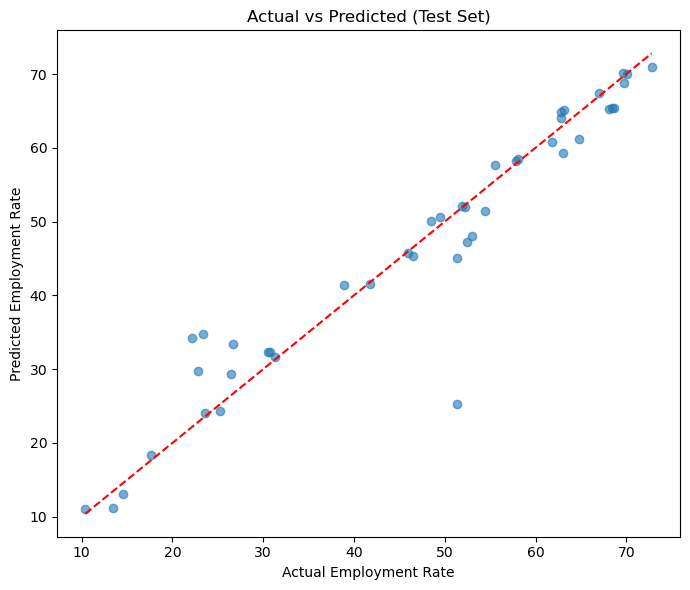

In [21]:
import matplotlib.pyplot as plt

best_model = gb  

y_pred = best_model.predict(X_test)

plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--'
)
plt.xlabel("Actual Employment Rate")
plt.ylabel("Predicted Employment Rate")
plt.title("Actual vs Predicted (Test Set)")
plt.tight_layout()
plt.savefig("../outputs/processed/preal_vs_pred.png")
plt.show()


In [22]:
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)

print("Train R2:", r2_score(y_train, train_pred))
print("Test R2 :", r2_score(y_test, test_pred))

Train R2: 0.994401624183587
Test R2 : 0.9163620166277988
